In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as img
from PIL import Image
import seaborn as sns

In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 19.8 MB/s 
     |████████████████████████████████| 1.6 MB 41.6 MB/s 


In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█▌                              | 30.5 MB 111.9 MB/s eta 0:00:06ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=m

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D,concatenate,Add,Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import BayesianOptimization
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from keras.applications.resnet import preprocess_input
import keras_tuner

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """


In [ ]:
keras.backend.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Dissertation')

In [ ]:
# Load the Train and Test Directories
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Training'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Testing'

(512, 512, 3)


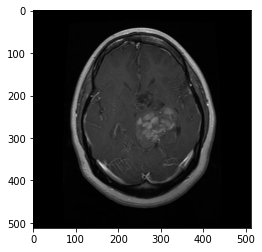

In [ ]:
# Glioma Tumor visualization
img_array = img.imread(train_dir + "/glioma_tumor/gg (1).jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

In [ ]:
# Load the Train and Test Directories for the cropped images
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Train_crop'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Test_crop'

In [ ]:
# Datagenerator for Train,Validation and Test
Generator = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.25,
                               rotation_range=30,
                               shear_range=30,
                               zoom_range=.15,
                              # width_shift_range=0.2,
                              # height_shift_range=0.2,
                              # shear_range=0.2,
                              # zoom_range=0.2,
                              # rotation_range=40,
                              horizontal_flip=True,
                              preprocessing_function=preprocess_input)
target_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [ ]:
train_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                color_mode ='rgb',
                                                class_mode='categorical',
                                                classes=target_labels,
                                                # shuffle = True,
                                                subset = 'training')   
valid_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size = 32,
                                                color_mode ='rgb',
                                                class_mode = 'categorical',
                                                classes = target_labels,
                                                # shuffle = True,
                                                subset = 'validation')
test_generator = Generator.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               color_mode='rgb',
                                               class_mode = 'categorical',
                                              #  shuffle = True,
                                               classes=target_labels)
print("Training batch classes: ", train_generator.class_indices)
print("Validation batch classes: ", valid_generator.class_indices)
print("Validation batch classes: ", test_generator.class_indices)

Found 2155 images belonging to 4 classes.
Found 715 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Training batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
def plot_cf_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes,cmap='YlOrBr')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class : " + class_label)

In [ ]:
# Plot confusion matrix 
def plot_confusion_matrices(conf_matrices, target_labels):
    fig, ax = plt.subplots(1, len(target_labels), figsize = (20, 4))

    for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrices, target_labels):
        plot_cf_matrix(cfs_matrix, axes, label, ["No", "Yes"])

    fig.tight_layout()
    plt.show()

In [ ]:
# Test function
def test_model(model, test_gen):
    y_pred = model.predict(x = test_generator, verbose = 1)
    print(y_pred.shape)
    return y_pred

<h3><b>ResNet50 Implementation

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
#Initialize the model
ResNet = Sequential()
Conv_base = keras.applications.ResNet50(include_top=False,
                                        input_shape=(224,224,3),
                                        pooling='max',
                                        classes=4,
                                        weights='imagenet')
for layer in Conv_base.layers:
  layer.trainable = False

ResNet.add(Conv_base)
ResNet.add(Flatten())
ResNet.add(Dense(4096,activation='relu'))
ResNet.add(BatchNormalization())
ResNet.add(Dropout(0.1))
ResNet.add(Dense(4096,activation='relu'))
ResNet.add(BatchNormalization())
ResNet.add(Dropout(0.1))
ResNet.add(Dense(1000,activation='relu'))
ResNet.add(BatchNormalization())
ResNet.add(Dropout(0.5))
ResNet.add(Dense(len(target_labels),activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step


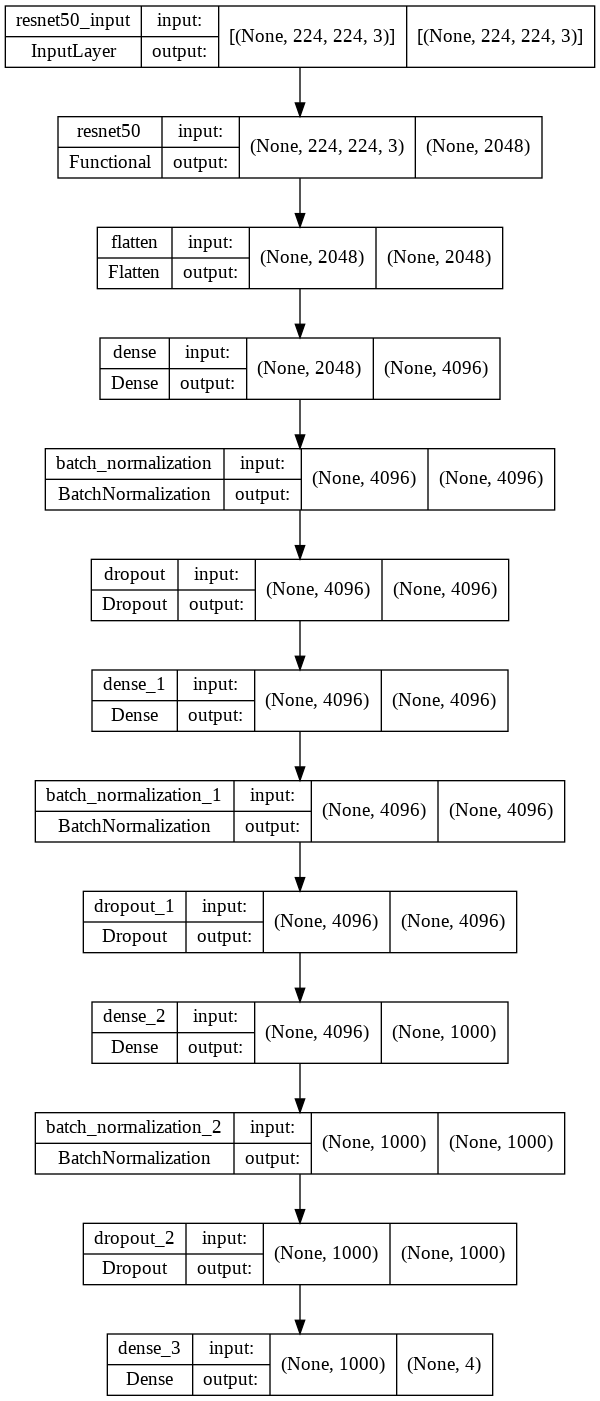

In [ ]:
plot_model(ResNet, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
ResNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                        

In [ ]:
ResNet.compile(optimizer=keras.optimizers.Adam(0.0001),
               loss=keras.losses.categorical_crossentropy,
               metrics=['categorical_accuracy','Recall'])

In [ ]:
mdck_cb = keras.callbacks.ModelCheckpoint(filepath='ResNet50.h5')
stop_cb = keras.callbacks.EarlyStopping(patience=45)
histRes = ResNet.fit(train_generator,
                     steps_per_epoch=len(train_generator),
                     epochs=50,
                     validation_data=valid_generator,
                     validation_steps=len(valid_generator),
                     callbacks=[stop_cb,mdck_cb])

Epoch 1/50
68/68 [==============================] - 488s 7s/step - loss: 1.8755 - categorical_accuracy: 0.4445 - recall: 0.3940 - val_loss: 2.1728 - val_categorical_accuracy: 0.2923 - val_recall: 0.2895
Epoch 2/50
68/68 [==============================] - 73s 1s/step - loss: 1.4766 - categorical_accuracy: 0.5216 - recall: 0.4724 - val_loss: 2.2621 - val_categorical_accuracy: 0.3147 - val_recall: 0.3063
Epoch 3/50
68/68 [==============================] - 67s 971ms/step - loss: 1.3822 - categorical_accuracy: 0.5425 - recall: 0.5007 - val_loss: 2.2436 - val_categorical_accuracy: 0.3161 - val_recall: 0.3119
Epoch 4/50
68/68 [==============================] - 77s 1s/step - loss: 1.3469 - categorical_accuracy: 0.5429 - recall: 0.5002 - val_loss: 1.6101 - val_categorical_accuracy: 0.3497 - val_recall: 0.3287
Epoch 5/50
68/68 [==============================] - 92s 1s/step - loss: 1.2653 - categorical_accuracy: 0.5638 - recall: 0.5276 - val_loss: 1.5047 - val_categorical_accuracy: 0.3888 - val_r

In [ ]:
X = pd.DataFrame(histRes.history)
print('validation accuracy',max(X['val_categorical_accuracy']))
print('Training accuracy',max(X['categorical_accuracy']))
print('Validation Recall:',max(X['val_recall']))
print('Training Recall:',max(X['recall']))

validation accuracy 0.6489510536193848
Training accuracy 0.717401385307312
Validation Recall: 0.5888111591339111
Training Recall: 0.6881670355796814


In [ ]:
X.to_csv('R50-TL.csv')

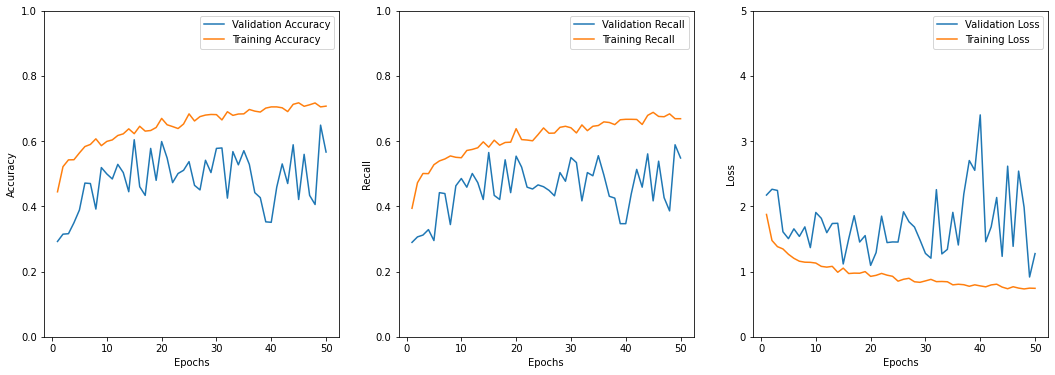

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['val_categorical_accuracy'],label='Validation Accuracy')
plt.plot(np.arange(1,len(X)+1),X['categorical_accuracy'],label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['val_recall'],label='Validation Recall')
plt.plot(np.arange(1,len(X)+1),X['recall'],label='Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['val_loss'],label='Validation Loss')
plt.plot(np.arange(1,len(X)+1),X['loss'],label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()

In [ ]:
y_pred = test_model(ResNet, test_generator)

13/13 [==============================] - 72s 6s/step
(394, 4)


In [ ]:
Y_pred = (y_pred > 0.5).astype(int)

In [ ]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_generator.labels)

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])

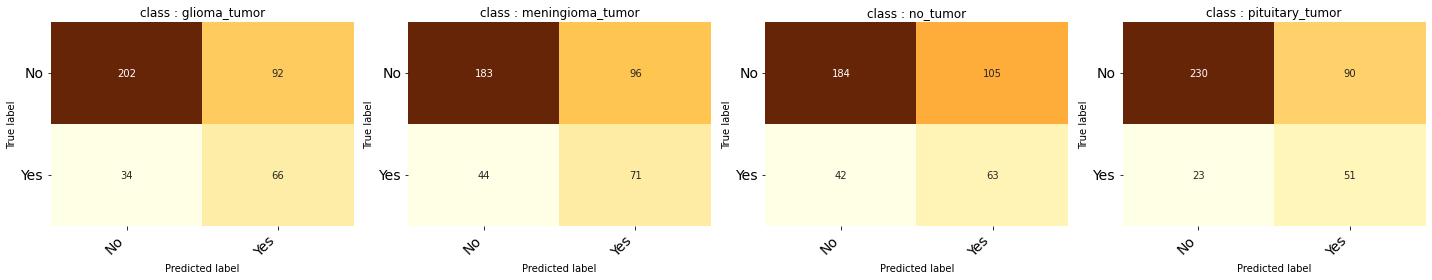

In [ ]:
plot_confusion_matrices(conf_matrices, target_labels)

<h2><b>Hyperparameter tuning of ResNet

In [ ]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.models import Sequential, load_model, Model

In [ ]:
def ResNettune(param):
  X_input = Input(shape= (224,224,3))
  X = Conv2D(filters=param.Int('Con1_fil',min_value = 64,max_value=96,step=16), 
             input_shape=(224,224,3), kernel_size=param.Choice('Con1_krn',values=[6,7,8]),
             strides=2, padding='same', activation='relu') (X_input)
  X = BatchNormalization()(X)
  X1 = MaxPooling2D(pool_size=param.Choice('MxP1_psz',values=[2,3,4]),
                  strides=2, 
                  padding='same') (X)
  #Convolutional Block 1         
  filter1 = param.Int('Bk1Con_fil1',min_value = 64,max_value=96,step=16)   
  filter2 = param.Int('Bk1Con_fil2',min_value = 256,max_value=320,step=32)
  kernel1 = param.Choice('Bk1Con_krn',values=[2,3,4])
  B1 = Conv2D(filters=filter1, 
              kernel_size=(1,1),
              strides=1, padding='valid', activation='relu') (X1)
  B1 = BatchNormalization(axis=3)(B1)
  B1 = Conv2D(filters=filter1, 
              kernel_size=kernel1,
              strides=1, padding='same', activation='relu') (B1)
  B1 = BatchNormalization(axis=3)(B1)
  B1 = Conv2D(filters=filter2, 
              kernel_size=(1,1),
              strides=1, padding='valid', activation='relu') (B1)
  B1 = BatchNormalization(axis=3)(B1)
  X1 = Conv2D(filters=filter2, 
              kernel_size=(1,1),
              strides=1, padding='valid', activation='relu') (X1)
  X1 = BatchNormalization(axis=3)(X1)
  B1 = Add()([B1,X1])
  B1 = Activation('relu')(B1)
  
  #Identity block 1
  I1 = Conv2D(filters=filter1, 
              kernel_size=(1,1),
              strides=1, padding='valid', activation='relu') (B1)
  I1 = BatchNormalization(axis=3)(I1)
  I1 = Conv2D(filters=filter1, 
              kernel_size=kernel1,
              strides=(1,1), padding='same', activation='relu') (I1)
  I1 = BatchNormalization(axis=3)(I1)
  I1 = Conv2D(filters=filter2, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I1)
  I1 = BatchNormalization(axis=3)(I1)
  I1 = Add()([I1,B1])
  I1 = Activation('relu')(I1)
  
  #Identity block 2
  I2 = Conv2D(filters=filter1, 
              kernel_size=(1,1),
              strides=1, padding='valid', activation='relu') (I1)
  I2 = BatchNormalization(axis=3)(I2)
  I2 = Conv2D(filters=filter1, 
              kernel_size=kernel1,
              strides=(1,1), padding='same', activation='relu') (I2)
  I2 = BatchNormalization(axis=3)(I2)
  I2 = Conv2D(filters=filter2, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I2)
  I2 = BatchNormalization(axis=3)(I2)
  I2 = Add()([I2,I1])
  I2 = Activation('relu')(I2)
  
  #Convolutional Block 2   
  filter3 = param.Int('Bk2Con_fil1',min_value = 128,max_value=192,step=32)               
  filter4 = param.Int('Bk2Con_fil2',min_value = 512,max_value=640,step=64) 
  kernel2 = param.Choice('Bk2Con_krn',values=[2,3,4])              
  B2 = Conv2D(filters=filter3, 
              kernel_size=(1,1),
              strides=2, padding='valid', activation='relu') (I2)
  B2 = BatchNormalization(axis=3)(B2)
  B2 = Conv2D(filters=filter3, 
              kernel_size=kernel2,
              strides=(1,1), padding='same', activation='relu') (B2)
  B2 = BatchNormalization(axis=3)(B2)
  B2 = Conv2D(filters=filter4, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (B2)
  B2 = BatchNormalization(axis=3)(B2)
  I2 = Conv2D(filters=filter4, 
              kernel_size=(1,1),
              strides=2, padding='valid', activation='relu') (I2)
  I2 = BatchNormalization(axis=3)(I2)
  B2 = Add()([B2,I2])
  B2 = Activation('relu')(B2)
  #Identity block 3
  I3 = Conv2D(filters=filter3, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (B2)
  I3 = BatchNormalization(axis=3)(I3)
  I3 = Conv2D(filters=filter3, 
              kernel_size=kernel2,
              strides=(1,1), padding='same', activation='relu') (I3)
  I3 = BatchNormalization(axis=3)(I3)
  I3 = Conv2D(filters=filter4, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I3)
  I3 = BatchNormalization(axis=3)(I3)
  I3 = Add()([I3,B2])
  I3 = Activation('relu')(I3)
  #Identity block 4
  I4 = Conv2D(filters=filter3, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I3)
  I4 = BatchNormalization(axis=3)(I4)
  I4 = Conv2D(filters=filter3, 
              kernel_size=kernel2,
              strides=(1,1), padding='same', activation='relu') (I4)
  I4 = BatchNormalization(axis=3)(I4)
  I4 = Conv2D(filters=filter4, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I4)
  I4 = BatchNormalization(axis=3)(I4)
  I4 = Add()([I4,I3])
  I4 = Activation('relu')(I4)
  #Identity block 5
  I5 = Conv2D(filters=filter3, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I4)
  I5 = BatchNormalization(axis=3)(I5)
  I5 = Conv2D(filters=filter3, 
              kernel_size=kernel2,
              strides=(1,1), padding='same', activation='relu') (I5)
  I5 = BatchNormalization(axis=3)(I5)
  I5 = Conv2D(filters=filter4, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I5)
  I5 = BatchNormalization(axis=3)(I5)
  I5 = Add()([I5,I4])
  I5 = Activation('relu')(I5)

  #Convolutional Block 3                
  filter5 = param.Int('Bk3Con_fil1',min_value = 256,max_value=320,step=32)
  filter6 = param.Int('Bk3Con_fil2',min_value = 1024,max_value=1280,step=128)
  kernel3 = param.Choice('Bk3Con_krn',values=[2,3,4])

  B3 = Conv2D(filters=filter5, 
              kernel_size=(1,1),
              strides=2, padding='valid', activation='relu') (I5)
  B3 = BatchNormalization(axis=3)(B3)
  B3 = Conv2D(filters=filter5, 
              kernel_size=kernel3,
              strides=(1,1), padding='same', activation='relu') (B3)
  B3 = BatchNormalization(axis=3)(B3)
  B3 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (B3)
  B3 = BatchNormalization(axis=3)(B3)
  I5 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=2, padding='valid', activation='relu') (I5)
  I5 = BatchNormalization(axis=3)(I5)
  B3 = Add()([B3,I5])
  B3 = Activation('relu')(B3)

  #Identity block 6
  I6 = Conv2D(filters=filter5, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (B3)
  I6 = BatchNormalization(axis=3)(I6)
  I6 = Conv2D(filters=filter5, 
              kernel_size=kernel3,
              strides=(1,1), padding='same', activation='relu') (I6)
  I6 = BatchNormalization(axis=3)(I6)
  I6 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I6)
  I6 = BatchNormalization(axis=3)(I6)
  I6 = Add()([I6,B3])
  I6 = Activation('relu')(I6)
  #Identity block 7
  I7 = Conv2D(filters=filter5, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I6)
  I7 = BatchNormalization(axis=3)(I7)
  I7 = Conv2D(filters=filter5, 
              kernel_size=kernel3,
              strides=(1,1), padding='same', activation='relu') (I7)
  I7 = BatchNormalization(axis=3)(I7)
  I7 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I7)
  I7 = BatchNormalization(axis=3)(I7)
  I7 = Add()([I7,I6])
  I7 = Activation('relu')(I7)
  #Identity block 8
  I8 = Conv2D(filters=filter5, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I7)
  I8 = BatchNormalization(axis=3)(I8)
  I8 = Conv2D(filters=filter5, 
              kernel_size=kernel3,
              strides=(1,1), padding='same', activation='relu') (I8)
  I8 = BatchNormalization(axis=3)(I8)
  I8 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I8)
  I8 = BatchNormalization(axis=3)(I8)
  I8 = Add()([I8,I7])
  I8 = Activation('relu')(I8)
  #Identity block 9
  I9 = Conv2D(filters=filter5, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I8)
  I9 = BatchNormalization(axis=3)(I9)
  I9 = Conv2D(filters=filter5, 
              kernel_size=kernel3,
              strides=(1,1), padding='same', activation='relu') (I9)
  I9 = BatchNormalization(axis=3)(I9)
  I9 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I9)
  I9 = BatchNormalization(axis=3)(I9)
  I9 = Add()([I9,I8])
  I9 = Activation('relu')(I9)
  #Identity block 10
  I10 = Conv2D(filters=filter5, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I9)
  I10 = BatchNormalization(axis=3)(I10)
  I10 = Conv2D(filters=filter5, 
              kernel_size=kernel3,
              strides=(1,1), padding='same', activation='relu') (I10)
  I10 = BatchNormalization(axis=3)(I10)
  I10 = Conv2D(filters=filter6, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I10)
  I10 = BatchNormalization(axis=3)(I10)
  I10 = Add()([I10,I9])
  I10 = Activation('relu')(I9)
  #Convolutional Block 4      
  filter7 = param.Int('Bk4Con_fil1',min_value = 512,max_value=640,step=64)    
  filter8 = param.Int('Bk4Con_fil2',min_value = 2048,max_value=2560,step=256)
  kernel4 = param.Choice('Bk4Con_krn',values=[2,3,4])
  B4 = Conv2D(filters=filter7, 
              kernel_size=(1,1),
              strides=2, padding='valid', activation='relu') (I10)
  B4 = BatchNormalization(axis=3)(B4)
  B4 = Conv2D(filters=filter7, 
              kernel_size=kernel4,
              strides=(1,1), padding='same', activation='relu') (B4)
  B4 = BatchNormalization(axis=3)(B4)
  B4 = Conv2D(filters=filter8, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (B4)
  B4 = BatchNormalization(axis=3)(B4)
  I10 = Conv2D(filters=filter8, 
              kernel_size=(1,1),
              strides=2, padding='valid', activation='relu') (I10)
  I10 = BatchNormalization(axis=3)(I10)
  B4 = Add()([B4,I10])
  B4 = Activation('relu')(B4)
  #Identity block 11
  I11 = Conv2D(filters=filter7, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (B4)
  I11 = BatchNormalization(axis=3)(I11)
  I11 = Conv2D(filters=filter7, 
              kernel_size=kernel4,
              strides=(1,1), padding='same', activation='relu') (I11)
  I11 = BatchNormalization(axis=3)(I11)
  I11 = Conv2D(filters=filter8, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I11)
  I11 = BatchNormalization(axis=3)(I11)
  I11 = Add()([I11,B4])
  I11 = Activation('relu')(I11)
  #Identity block 12
  I12 = Conv2D(filters=filter7, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I11)
  I12 = BatchNormalization(axis=3)(I12)
  I12 = Conv2D(filters=filter7, 
              kernel_size=kernel4,
              strides=(1,1), padding='same', activation='relu') (I12)
  I12 = BatchNormalization(axis=3)(I12)
  I12 = Conv2D(filters=filter8, 
              kernel_size=(1,1),
              strides=(1,1), padding='valid', activation='relu') (I12)
  I12 = BatchNormalization(axis=3)(I12)
  I12 = Add()([I12,I11])
  I12 = Activation('relu')(I12)
  # Average Pooling
  M = AveragePooling2D(pool_size=2, 
                  padding='same') (I12) 
  # Fully connected network
  F  = Flatten()(M)
  F1 = Dense(param.Int('Dens1',min_value=4096,max_value=6120,step=512), activation='relu')(F)
  F2 = Dense(param.Int('Dens2',min_value=1000,max_value=1256,step=128), activation='relu')(F1)
  F3 = Dense( len(target_labels),activation='softmax')(F2)
  ResNet50HP = Model(X_input,F3)
  ResNet50HP.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer= keras.optimizers.Adam(param.Choice('learning_rate',values=[5e-4,1e-4])),metrics=['accuracy','Recall'])
  return ResNet50HP

In [ ]:
ResNet_bo_tun = BayesianOptimization(ResNettune,
                            objective=[keras_tuner.Objective('val_recall',direction='max'),
                                       keras_tuner.Objective('val_accuracy',direction='max'),
                                       keras_tuner.Objective('val_loss',direction='min'),],
                            max_trials=7,
                            # num_initial_points = 2,
                            # alpha = 0.0001,
                            directory ='ResNet_BO',
                            project_name='Dissert',                            
                            overwrite=True)

In [ ]:
ResNet_bo_tun.search(train_generator,epochs=6,validation_data=valid_generator)

In [ ]:
ResNet_bo_tun.get_best_hyperparameters()[0].values

{'Con1_fil': 64,
 'Con1_krn': 7,
 'MxP1_psz': 2,
 'Bk1Con_fil1': 96,
 'Bk1Con_fil2': 256,
 'Bk1Con_krn': 3,
 'Bk2Con_fil1': 192,
 'Bk2Con_fil2': 576,
 'Bk2Con_krn': 4,
 'Bk3Con_fil1': 288,
 'Bk3Con_fil2': 1152,
 'Bk3Con_krn': 4,
 'Bk4Con_fil1': 640,
 'Bk4Con_fil2': 2560,
 'Bk4Con_krn': 2,
 'Dens1': 4608,
 'Dens2': 1128,
 'learning_rate': 0.0005}

In [ ]:
ResNet_bo_tun.results_summary()

Results summary
Results in ResNet_BO/Dissert
Showing 10 best trials
Trial summary
Hyperparameters:
Con1_fil: 64
Con1_krn: 7
MxP1_psz: 2
Bk1Con_fil1: 96
Bk1Con_fil2: 256
Bk1Con_krn: 3
Bk2Con_fil1: 192
Bk2Con_fil2: 576
Bk2Con_krn: 4
Bk3Con_fil1: 288
Bk3Con_fil2: 1152
Bk3Con_krn: 4
Bk4Con_fil1: 640
Bk4Con_fil2: 2560
Bk4Con_krn: 2
Dens1: 4608
Dens2: 1128
learning_rate: 0.0005
Score: 0.958106130361557
Trial summary
Hyperparameters:
Con1_fil: 64
Con1_krn: 6
MxP1_psz: 3
Bk1Con_fil1: 96
Bk1Con_fil2: 256
Bk1Con_krn: 2
Bk2Con_fil1: 192
Bk2Con_fil2: 576
Bk2Con_krn: 4
Bk3Con_fil1: 288
Bk3Con_fil2: 1280
Bk3Con_krn: 4
Bk4Con_fil1: 640
Bk4Con_fil2: 2304
Bk4Con_krn: 2
Dens1: 4096
Dens2: 1000
learning_rate: 0.0005
Score: 0.9882866740226746
Trial summary
Hyperparameters:
Con1_fil: 64
Con1_krn: 6
MxP1_psz: 2
Bk1Con_fil1: 96
Bk1Con_fil2: 256
Bk1Con_krn: 3
Bk2Con_fil1: 192
Bk2Con_fil2: 512
Bk2Con_krn: 4
Bk3Con_fil1: 320
Bk3Con_fil2: 1280
Bk3Con_krn: 4
Bk4Con_fil1: 640
Bk4Con_fil2: 2560
Bk4Con_krn: 2
Dens1:

In [ ]:
res = ResNet_bo_tun.get_best_models(3)

In [ ]:
res[0].summary()

In [ ]:
mdck_cb = keras.callbacks.ModelCheckpoint(filepath='ResNet50HP.h5')
stop_cb = keras.callbacks.EarlyStopping(patience=45)
hist00 = res[0].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator),
                                callbacks=[stop_cb,mdck_cb])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
68/68 [==============================] - 117s 2s/step - loss: 1.2276 - accuracy: 0.5090 - recall: 0.3072 - val_loss: 1.6829 - val_accuracy: 0.3259 - val_recall: 0.1706
Epoch 2/50
68/68 [==============================] - 63s 920ms/step - loss: 1.1018 - accuracy: 0.5578 - recall: 0.4000 - val_loss: 2.5894 - val_accuracy: 0.2951 - val_recall: 0.2895
Epoch 3/50
68/68 [==============================] - 60s 879ms/step - loss: 0.9876 - accuracy: 0.5749 - recall: 0.4204 - val_loss: 2.1773 - val_accuracy: 0.3706 - val_recall: 0.3427
Epoch 4/50
68/68 [==============================] - 61s 899ms/step - loss: 0.8782 - accuracy: 0.6469 - recall: 0.5244 - val_loss: 1.8785 - val_accuracy: 0.4042 - val_recall: 0.3678
Epoch 5/50
68/68 [==============================] - 60s 886ms/step - loss: 0.8496 - accuracy: 0.6575 - recall: 0.5587 - val_loss: 1.5228 - val_accuracy: 0.4895 - val_recall: 0.4476
Epoch 6/50
68/68 [==============================] - 61s 888ms/step - loss: 0.7777 - accuracy: 0.6

In [ ]:
hist01 = res[1].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 56s 735ms/step - loss: 1.3153 - accuracy: 0.5081 - recall: 0.2845 - val_loss: 1.5543 - val_accuracy: 0.3077 - val_recall: 0.1846
Epoch 2/50
68/68 [==============================] - 48s 708ms/step - loss: 1.1245 - accuracy: 0.5466 - recall: 0.3796 - val_loss: 1.4436 - val_accuracy: 0.3804 - val_recall: 0.3217
Epoch 3/50
68/68 [==============================] - 49s 713ms/step - loss: 1.0122 - accuracy: 0.6028 - recall: 0.4636 - val_loss: 2.3192 - val_accuracy: 0.3399 - val_recall: 0.3133
Epoch 4/50
68/68 [==============================] - 49s 721ms/step - loss: 0.9481 - accuracy: 0.6376 - recall: 0.5030 - val_loss: 1.3796 - val_accuracy: 0.4657 - val_recall: 0.4042
Epoch 5/50
68/68 [==============================] - 49s 724ms/step - loss: 0.8740 - accuracy: 0.6432 - recall: 0.5545 - val_loss: 1.4245 - val_accuracy: 0.4490 - val_recall: 0.3622
Epoch 6/50
68/68 [==============================] - 49s 710ms/step - loss: 0.8124 - accuracy: 0

In [ ]:
hist02 = res[2].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 54s 716ms/step - loss: 1.6475 - accuracy: 0.4599 - recall: 0.2390 - val_loss: 1.3971 - val_accuracy: 0.2937 - val_recall: 0.0000e+00
Epoch 2/50
68/68 [==============================] - 47s 693ms/step - loss: 1.5653 - accuracy: 0.4821 - recall: 0.2738 - val_loss: 2.0592 - val_accuracy: 0.2881 - val_recall: 0.2881
Epoch 3/50
68/68 [==============================] - 48s 695ms/step - loss: 1.2584 - accuracy: 0.5188 - recall: 0.3309 - val_loss: 1.9252 - val_accuracy: 0.2993 - val_recall: 0.2657
Epoch 4/50
68/68 [==============================] - 48s 696ms/step - loss: 1.0986 - accuracy: 0.5457 - recall: 0.3499 - val_loss: 2.3294 - val_accuracy: 0.3329 - val_recall: 0.3203
Epoch 5/50
68/68 [==============================] - 47s 693ms/step - loss: 1.0069 - accuracy: 0.5694 - recall: 0.3995 - val_loss: 2.1184 - val_accuracy: 0.3315 - val_recall: 0.2909
Epoch 6/50
68/68 [==============================] - 47s 694ms/step - loss: 0.9170 - accurac

In [ ]:
hist03 = res[3].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

In [ ]:
hist04 = res[4].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

In [ ]:
# X = pd.DataFrame(histRes.history)
Y0 = pd.DataFrame(hist00.history)
Y1 = pd.DataFrame(hist01.history)
Y2 = pd.DataFrame(hist02.history)
# Y3 = pd.DataFrame(hist03.history)
# Y4 = pd.DataFrame(hist04.history)

In [ ]:
Y0.to_csv('R50-00.csv')
Y1.to_csv('R50-01.csv')
Y2.to_csv('R50-02.csv')
# Y3.to_csv('R50-03.csv')
# Y4.to_csv('R50-04.csv')

In [1]:
X = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-TL.csv')
Y0 = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-00.csv')
Y1 = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-01.csv')
Y2 = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-02.csv')
Y3 = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-trial1.csv')
Y4 = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-trial2.csv')
# Y2 = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-tbest1.csv')

NameError: ignored

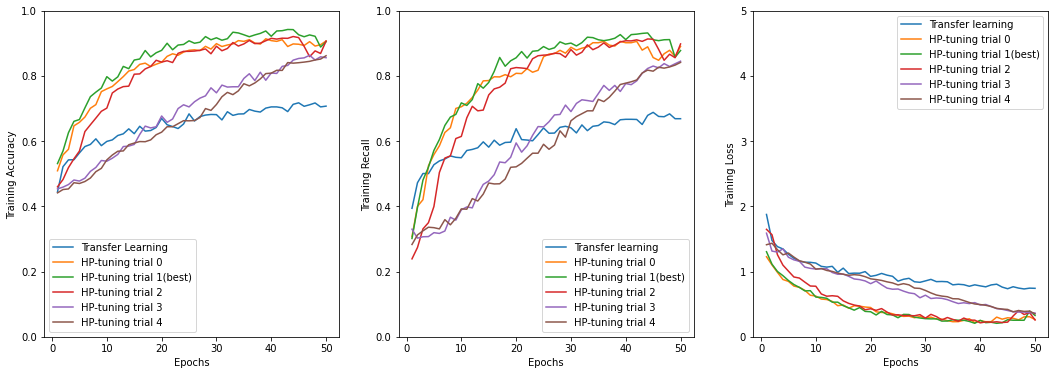

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['categorical_accuracy'],label='Transfer Learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['accuracy'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['accuracy'],label='HP-tuning trial 1(best)')
plt.plot(np.arange(1,len(Y2)+1),Y2['accuracy'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['accuracy'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y3)+1),Y4['accuracy'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['recall'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['recall'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['recall'],label='HP-tuning trial 1(best)')
plt.plot(np.arange(1,len(Y2)+1),Y2['recall'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['recall'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['recall'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Training Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['loss'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['loss'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['loss'],label='HP-tuning trial 1(best)')
plt.plot(np.arange(1,len(Y2)+1),Y2['loss'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['loss'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['loss'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0,5)
plt.legend()

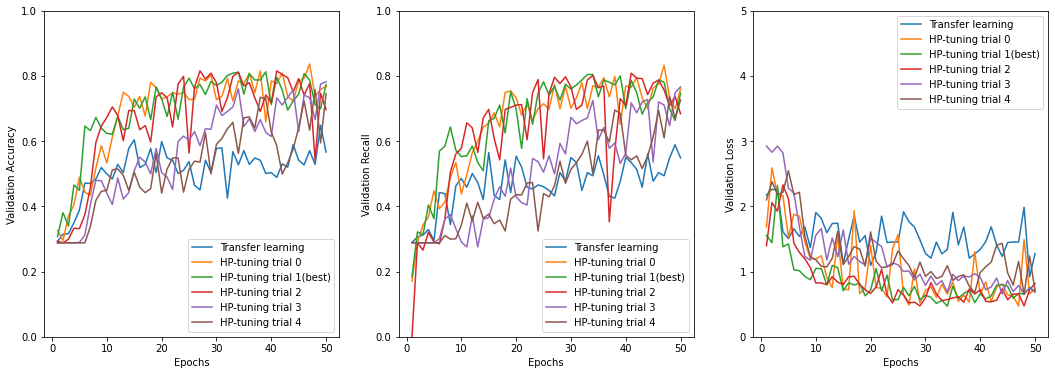

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['val_categorical_accuracy'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_accuracy'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_accuracy'],label='HP-tuning trial 1(best)')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_accuracy'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_accuracy'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_accuracy'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['val_recall'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_recall'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_recall'],label='HP-tuning trial 1(best)')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_recall'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_recall'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_recall'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Validation Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['val_loss'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_loss'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_loss'],label='HP-tuning trial 1(best)')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_loss'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_loss'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_loss'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.ylim(0,5)
plt.legend()

In [ ]:
y_pred = test_model(ResNet50_bo, test_generator)

13/13 [==============================] - 6s 380ms/step
(394, 4)


In [ ]:
Y_pred = (y_pred > 0.5).astype(int)

In [ ]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_generator.labels)

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])

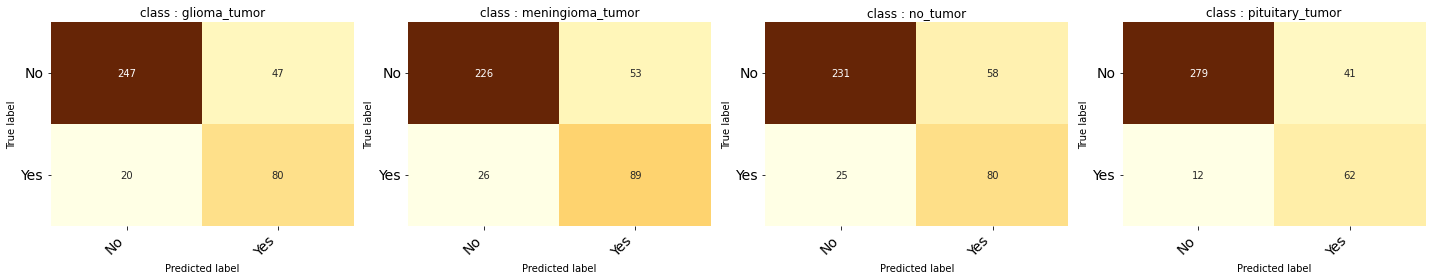

In [ ]:
plot_confusion_matrices(conf_matrices, target_labels)

In [ ]:
AHP = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alex04.csv')
RHP = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-02.csv')
VHP = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG-trial2.csv')

In [ ]:
ATL = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alx-TL.csv')
RTL = pd.read_csv('/content/gdrive/My Drive/Dissertation/R50-TL.csv')
VTL = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG-TL.csv')

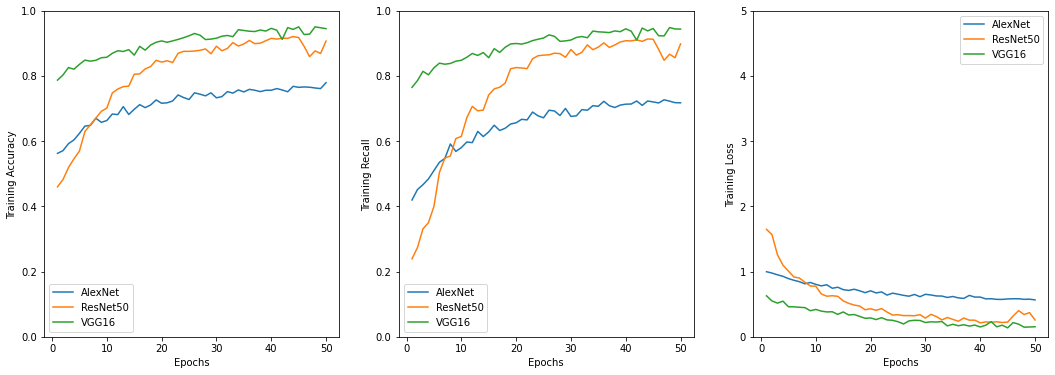

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(AHP)+1),AHP['categorical_accuracy'],label='AlexNet')
plt.plot(np.arange(1,len(RHP)+1),RHP['accuracy'],label='ResNet50')
plt.plot(np.arange(1,len(VHP)+1),VHP['categorical_accuracy'],label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(AHP)+1),AHP['recall'],label='AlexNet')
plt.plot(np.arange(1,len(RHP)+1),RHP['recall'],label='ResNet50')
plt.plot(np.arange(1,len(VHP)+1),VHP['recall'],label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Training Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(AHP)+1),AHP['loss'],label='AlexNet')
plt.plot(np.arange(1,len(RHP)+1),RHP['loss'],label='ResNet50')
plt.plot(np.arange(1,len(VHP)+1),VHP['loss'],label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0,5)
plt.legend()

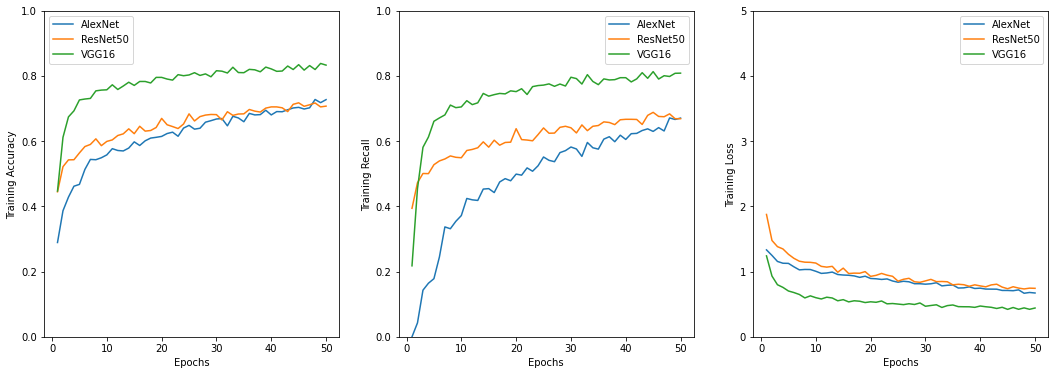

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(ATL)+1),ATL['categorical_accuracy'],label='AlexNet')
plt.plot(np.arange(1,len(RTL)+1),RTL['categorical_accuracy'],label='ResNet50')
plt.plot(np.arange(1,len(VTL)+1),VTL['categorical_accuracy'],label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(ATL)+1),ATL['recall'],label='AlexNet')
plt.plot(np.arange(1,len(RTL)+1),RTL['recall'],label='ResNet50')
plt.plot(np.arange(1,len(VTL)+1),VTL['recall'],label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Training Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(ATL)+1),ATL['loss'],label='AlexNet')
plt.plot(np.arange(1,len(RTL)+1),RTL['loss'],label='ResNet50')
plt.plot(np.arange(1,len(VTL)+1),VTL['loss'],label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0,5)
plt.legend()